In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

In [ ]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

In [ ]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)


In [ ]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to('cuda')

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

In [ ]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

In [ ]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

In [ ]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

In [ ]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

In [ ]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

In [ ]:

# standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += n**-0.5 * torch.randn(768)

print(x.std())

In [ ]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

In [ ]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # <-- have to add back the "normalizer"!
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])


6.0000003953509464e-05


/var/folders/4b/9zm9ynh11jd78x84rjs_32pm0000gn/T/ipykernel_7654/4059046716.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'LR Schedule')

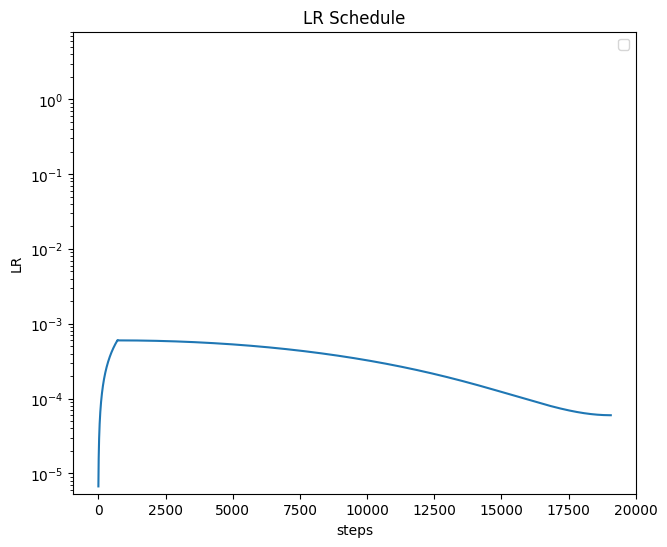

In [ ]:
# plot how warmup + cosine decay looks like for the LR schedule
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

MAX_STEPS = 19073 # 10b tokens divided by 0.5M batch size. If you want to train 4 epochs, then multiply this number by 4
MAX_LR = 6e-4 # as per gpt3 paper
MIN_LR = MAX_LR * 0.1 # as per gpt3 paper
WARM_STEPS = 1024

lr = []
steps = [i for i in range(MAX_STEPS)]

for step in range(19073):
    # Linear warmup for the warmup steps
        if step < WARM_STEPS:
            lr.append(MAX_LR * (step + 8) / WARM_STEPS)
            continue
        
        # If step > lr_decay_steps, then return min_lr
        if step > MAX_STEPS:
            lr.append(MIN_LR)
            continue
        
        # in between, use cosine decay down to min learning rate
        decay_ratio = (step - WARM_STEPS) / (MAX_STEPS- WARM_STEPS)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts from 1 and goes to 0
        lr.append(MIN_LR + coeff * (MAX_LR - MIN_LR))
        continue

print(lr[-1])
# create figure
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(steps, lr)
plt.xlabel("steps")
plt.ylabel("LR")
plt.yscale('log')
plt.ylim(top=8.0)
plt.legend()
plt.title("LR Schedule")

Min Train Loss: 2.99567
Min Validation Loss: 3.2758
Max Hellaswag eval: 0.304


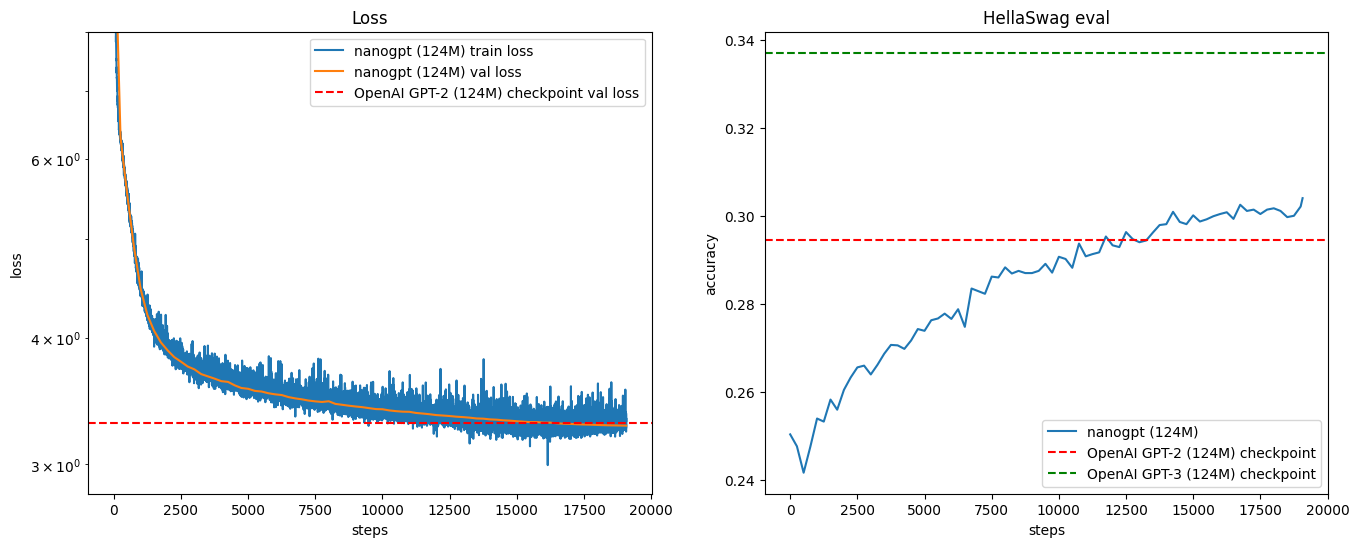

In [71]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=8.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))